Files already downloaded and verified
Files already downloaded and verified
model pretrained: 1


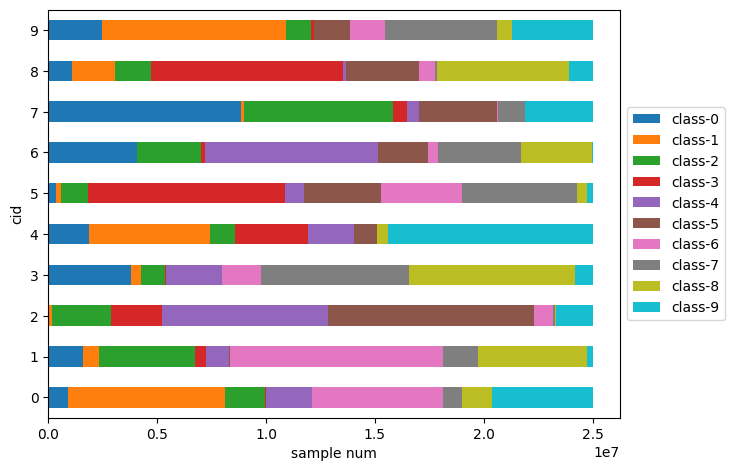

AttributeError: 'PartitionedCIFAR10' object has no attribute 'data_indices'

In [5]:
import sys
import os
import copy
import torch
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

sys.path.append("../")

cwd = os.getcwd()
project_root = os.path.abspath(os.path.join(cwd, "../.."))
sys.path.append(project_root)

# configuration
from munch import Munch
from fedlab.models.mlp import MLP
from fedlab.models.build_model import build_model
from fedlab.utils.dataset.functional import partition_report
from fedlab.utils.fednoro_utils import add_noise, set_seed, set_output_files, get_output, get_current_consistency_weight, identify_noise_type

args = Munch

args.total_client = 10
args.alpha = 0.5
args.seed = 42
args.preprocess = True
args.cuda = False
args.dataname = "cifar10"
args.model = "Resnet18"
args.pretrained = 1
args.num_users = args.total_client

if args.dataname == "cifar10":
    args.n_classes = 10

#args.device = "cuda" if torch.cuda.is_available() else "cpu"
args.device = "cpu"



# We provide a example usage of patitioned CIFAR10 dataset
# Download raw CIFAR10 dataset and partition them according to given configuration

from torchvision import transforms
from fedlab.contrib.dataset.partitioned_cifar10 import PartitionedCIFAR10

fed_cifar10 = PartitionedCIFAR10(root="../datasets/cifar10/",
                         path="../datasets/cifar10/fedcifar10/",
                         dataname = args.dataname,
                         num_clients=args.total_client,
                         partition="dirichlet",
                         dir_alpha=args.alpha,
                         seed=args.seed,
                         preprocess=args.preprocess,
                         download=True,
                         verbose=True,
                         transform=transforms.ToTensor())

dataset = fed_cifar10.get_dataset(0) # get the 0-th client's dataset
dataloader = fed_cifar10.get_dataloader(0, batch_size=128) # get the 0-th client's dataset loader with batch size 128

model = build_model(args)

# generate partition report
csv_file = "./partition-reports/cifar10_hetero_dir_0.3_10clients.csv"
partition_report(fed_cifar10.targets_train, fed_cifar10.data_indices_train, 
                 class_num=args.n_classes, 
                 verbose=False, file=csv_file)


hetero_dir_part_df = pd.read_csv(csv_file,header=0)
hetero_dir_part_df = hetero_dir_part_df.set_index('cid')
col_names = [f"class-{i}" for i in range(args.n_classes)]
for col in col_names:
    hetero_dir_part_df[col] = (hetero_dir_part_df[col] * hetero_dir_part_df['TotalAmount']).astype(int)

#select first 10 clients for bar plot
hetero_dir_part_df[col_names].iloc[:10].plot.barh(stacked=True)  
plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('sample num')
plt.savefig(f"./imgs/cifar10_hetero_dir_0.3_10clients.png", dpi=400, bbox_inches = 'tight')
plt.show()

#noise
args.level_n_lowerb = 0.3
args.level_n_upperb = 0.5
args.level_n_system = 0.4
args.n_type = "random"

y_train = np.array(fed_cifar10.targets_train)
y_train_noisy, gamma_s, real_noise_level = add_noise(args, y_train, fed_cifar10.data_indices_train)
fed_cifar10.targets_train = y_train_noisy

# generate partition report
csv_file = "./partition-reports/cifar10_dir_aft_noise_0.3_10clients.csv"
partition_report(fed_cifar10.targets_train, fed_cifar10.data_indices_train, 
                 class_num=args.n_classes, 
                 verbose=False, file=csv_file)


hetero_dir_part_df = pd.read_csv(csv_file,header=0)
hetero_dir_part_df = hetero_dir_part_df.set_index('cid')
col_names = [f"class-{i}" for i in range(args.n_classes)]
for col in col_names:
    hetero_dir_part_df[col] = (hetero_dir_part_df[col] * hetero_dir_part_df['TotalAmount']).astype(int)

#select first 10 clients for bar plot
hetero_dir_part_df[col_names].iloc[:10].plot.barh(stacked=True)  
plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('sample num')
plt.savefig(f"./imgs/cifar10_dir_aft_noise_0.3_10clients.png", dpi=400, bbox_inches = 'tight')
plt.show()

In [2]:

# client
from fedlab.contrib.algorithm.basic_client import SGDSerialClientTrainer, SGDClientTrainer

# local train configuration
args.epochs = 5
args.batch_size = 128
args.lr = 0.1

trainer = SGDSerialClientTrainer(model, args.total_client, cuda=args.cuda) # serial trainer
# trainer = SGDClientTrainer(model, cuda=True) # single trainer

trainer.setup_dataset(fed_cifar10)
trainer.setup_optim(args.epochs, args.batch_size, args.lr)

# server
from fedlab.contrib.algorithm.basic_server import SyncServerHandler

# global configuration
args.com_round = 10
args.sample_ratio = 0.1

handler = SyncServerHandler(model=model, global_round=args.com_round, sample_ratio=args.sample_ratio, cuda=args.cuda)


from fedlab.utils.functional import evaluate
from fedlab.core.standalone import StandalonePipeline

from torch import nn
from torch.utils.data import DataLoader
import torchvision

class EvalPipeline(StandalonePipeline):
    def __init__(self, handler, trainer, test_loader):
        super().__init__(handler, trainer)
        self.test_loader = test_loader 
        self.loss = []
        self.acc = []
        
    def main(self):
        t=0
        while self.handler.if_stop is False:
            # server side
            sampled_clients = self.handler.sample_clients()
            broadcast = self.handler.downlink_package
            
            # client side
            self.trainer.local_process(broadcast, sampled_clients)
            uploads = self.trainer.uplink_package

            # server side
            for pack in uploads:
                self.handler.load(pack)

            loss, acc = evaluate(self.handler.model, nn.CrossEntropyLoss(), self.test_loader)
            print("Round {}, Loss {:.4f}, Test Accuracy {:.4f}".format(t, loss, acc))
            t+=1
            self.loss.append(loss)
            self.acc.append(acc)
    
    def show(self):
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))

        # Plot loss
        axs[0].plot(np.arange(len(self.loss)), self.loss, color='blue')
        axs[0].set_title('Loss')
        axs[0].set_xlabel('Communication Round')
        axs[0].set_ylabel('Loss')

        # Plot accuracy
        axs[1].plot(np.arange(len(self.acc)), self.acc, color='red')
        axs[1].set_title('Accuracy')
        axs[1].set_xlabel('Communication Round')
        axs[1].set_ylabel('Accuracy')

        plt.savefig(f"./imgs/cifar10_hetero_dir_loss_accuracy.png", dpi=400, bbox_inches = 'tight')
        plt.tight_layout()
        plt.show()
        
    
        
test_data = torchvision.datasets.CIFAR10(root="../datasets/cifar10/",
                                       train=False,
                                       transform=transforms.ToTensor())
test_loader = DataLoader(test_data, batch_size=1024)

standalone_eval = EvalPipeline(handler=handler, trainer=trainer, test_loader=test_loader)
standalone_eval.main()

standalone_eval.show()


ModuleNotFoundError: No module named 'fedlab'